In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mer-sliced/skripsi_MER_sliced/X_MER_sliced.npy
/kaggle/input/mer-sliced/skripsi_MER_sliced/Y_1_sliced.npy
/kaggle/input/mer-sliced/skripsi_MER_sliced/Y_2_sliced.npy


In [2]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler


import numpy as np

import pylab as plt
import pandas as pd
import h5py


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import datetime
import warnings

In [3]:
def split_dataset(X, Y, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, stratify=False, random_state=42):
    """
    Splits feature (X) and label (Y) datasets into training, validation, and test sets,
    and normalizes the features using StandardScaler.

    Parameters:
        X (array-like): Feature dataset.
        Y (array-like): Labels corresponding to X.
        train_ratio (float): Proportion of the data for training.
        val_ratio (float): Proportion of the data for validation.
        test_ratio (float): Proportion of the data for testing.
        stratify (bool): Whether to stratify the split based on labels.
        random_state (int): Seed for reproducibility.

    Returns:
        tuple: (X_train, X_val, X_test, Y_train, Y_val, Y_test)
    """
    assert train_ratio + val_ratio + test_ratio == 1, "Ratios must sum to 1."

    stratify_labels = Y if stratify else None

    # First, split data into train and temp (val + test)
    X_train, X_temp, Y_train, Y_temp = train_test_split(
        X, Y, test_size=(val_ratio + test_ratio), stratify=stratify_labels, random_state=random_state
    )

    # Determine stratification for second split
    stratify_labels_temp = Y_temp if stratify else None

    # Split temp into validation and test sets
    X_val, X_test, Y_val, Y_test = train_test_split(
        X_temp, Y_temp, test_size=(test_ratio / (val_ratio + test_ratio)), stratify=stratify_labels_temp, random_state=random_state
    )

    # Normalize features using StandardScaler, handling 3D input
    scaler = StandardScaler()
    if X_train.ndim == 3:
        num_samples, time_steps, num_features = X_train.shape

        X_train_reshaped = X_train.reshape(-1, num_features)
        X_val_reshaped = X_val.reshape(-1, num_features)
        X_test_reshaped = X_test.reshape(-1, num_features)

        X_train_scaled = scaler.fit_transform(X_train_reshaped)
        X_val_scaled = scaler.transform(X_val_reshaped)
        X_test_scaled = scaler.transform(X_test_reshaped)

        X_train = X_train_scaled.reshape(num_samples, time_steps, num_features)
        X_val = X_val_scaled.reshape(X_val.shape[0], time_steps, num_features)
        X_test = X_test_scaled.reshape(X_test.shape[0], time_steps, num_features)
    else:
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [4]:
X = np.load("/kaggle/input/mer-sliced/skripsi_MER_sliced/X_MER_sliced.npy")


Y1 = np.load("/kaggle/input/mer-sliced/skripsi_MER_sliced/Y_1_sliced.npy")
Y2 = np.load("/kaggle/input/mer-sliced/skripsi_MER_sliced/Y_2_sliced.npy")

Y = np.concatenate([Y1, Y2], axis=0)

In [5]:
X.shape

(75348, 3000, 1)

In [6]:
Y.shape

(75348, 3000, 1)

# balance dataset

In [7]:
import numpy as np

# Misalnya X dan Y bentuknya: (75348, 3000, 1)

# Cari indeks dengan setidaknya satu nilai 1 (positif)
pos_indices = np.where(np.any(Y == 1, axis=(1, 2)))[0]

# Cari indeks yang semuanya 0 (negatif)
neg_indices = np.where(np.all(Y == 0, axis=(1, 2)))[0]

# Jumlah sampel minimum untuk disamakan
num_samples = min(len(pos_indices), len(neg_indices))

# Pilih secara acak
pos_sample_indices = np.random.choice(pos_indices, num_samples, replace=False)
neg_sample_indices = np.random.choice(neg_indices, num_samples, replace=False)

# Gabungkan dan acak indeks
balanced_indices = np.concatenate([pos_sample_indices, neg_sample_indices])
np.random.shuffle(balanced_indices)

# Ambil data seimbang
X_balanced = X[balanced_indices]
Y_balanced = Y[balanced_indices]

print(f"Balanced X shape: {X_balanced.shape}")
print(f"Balanced Y shape: {Y_balanced.shape}")


Balanced X shape: (32460, 3000, 1)
Balanced Y shape: (32460, 3000, 1)


In [8]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = split_dataset(X_balanced, Y_balanced, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, stratify=False, random_state=42)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, LSTM, Bidirectional, Dense, ReLU



# Model Definition
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
lstm_units = 64
dropout_rate = 0.2

model = Sequential([
    # Convolutional feature extraction
    Conv1D(filters=64, kernel_size=5, padding='same', activation='relu', input_shape=input_shape),
    Dropout(dropout_rate),
    ReLU(),

    # LSTM layers
    LSTM(lstm_units, return_sequences=True),
    #ReLU(),
    Dropout(dropout_rate),

    
    Bidirectional(LSTM(32, return_sequences=True)),
    #ReLU(),
    Dropout(dropout_rate),

    LSTM(lstm_units, return_sequences=True),
    #ReLU(),
    Dropout(dropout_rate),

    # Dense layers
    Dense(64),
    ReLU(),

    Dense(1, activation='sigmoid'),
])


# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 3000, 64)            │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3000, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 3000, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 3000, 64)            │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3000, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 3000, 64)            │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3000, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 3000, 64)            │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3000, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3000, 64)            │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 3000, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3000, 1)             │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,489 (373.00 KB)

 Trainable params: 95,489 (373.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
config = model.get_config()
print(config)

{'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 3000, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv1D', 'config': {'name': 'conv1d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 64, 'kernel_size': (5,), 'strides': (1,), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1,), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None},

In [12]:
weights = model.get_weights()
print(weights)


[array([[[ 0.01434052,  0.04949886, -0.02527714,  0.04481727,
          0.11896719,  0.11520256, -0.08799076,  0.0192547 ,
         -0.08942789, -0.05038261,  0.07761645, -0.11792774,
         -0.11354853,  0.04893067,  0.01078281, -0.00633729,
          0.08179627,  0.01401447, -0.0772499 , -0.0274596 ,
         -0.11450204, -0.08612767, -0.04905796,  0.03418063,
         -0.05847374,  0.03357488, -0.03630999,  0.05943754,
         -0.01357912,  0.07036969, -0.00582476, -0.03068466,
          0.12339427, -0.13546151, -0.01226246,  0.04927494,
          0.05462016,  0.07919945,  0.13153704, -0.12246789,
          0.07930395,  0.12677114,  0.01877283, -0.1276134 ,
          0.09094435,  0.03736934, -0.07803172, -0.00461563,
          0.07988337, -0.0425522 ,  0.04104899, -0.07667529,
         -0.0314794 ,  0.0998019 ,  0.08079742,  0.00126307,
          0.12917657, -0.07496546, -0.01081109,  0.10663041,
         -0.06167784, -0.0760352 , -0.06278259, -0.10472088]],

       [[-0.05938413

# Training

In [13]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint


In [14]:
class PeriodicSaver(tf.keras.callbacks.Callback):
    def __init__(self, interval=10, prefix='model'):
        super().__init__()
        self.interval = interval
        self.prefix = prefix

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            filepath = f"{self.prefix}_epoch_{epoch+1}.h5"  # Use .keras if preferred
            self.model.save(filepath)
            print(f"\nSaved model to {filepath}")

In [15]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy') >= 0.97 and logs.get('val_accuracy') >= 0.96):
                print("\n Accuracy is more than 97%, stopping...")
                self.model.stop_training = True


In [16]:
class ToleranceAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_accuracy', min_delta=1e-4, patience=5):
        super().__init__()
        self.monitor = monitor
        self.min_delta = min_delta
        self.patience = patience
        self.wait = 0
        self.best = None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)

        if current is None:
            return

        if self.best is None:
            self.best = current
        elif (current - self.best) < self.min_delta:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nEarly stopping: no improvement in {self.monitor} for {self.patience} epochs.")
                self.model.stop_training = True
        else:
            self.best = current
            self.wait = 0


In [17]:
toleranceCallback = ToleranceAccuracyCallback(
    monitor='val_accuracy',
    min_delta=1e-4,
    patience=30
)

In [18]:
customCallback = myCallback()

In [19]:
periodic_saver = PeriodicSaver(interval=10, prefix='stft_model_200')


In [20]:
# Training
epochs = 100
batch_size = 64 

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=[customCallback, toleranceCallback, periodic_saver]
)

Epoch 1/100


I0000 00:00:1747267750.866936      72 cuda_dnn.cc:529] Loaded cuDNN version 90300


356/356 ━━━━━━━━━━━━━━━━━━━━ 180s 484ms/step - accuracy: 0.8833 - loss: 0.3940 - val_accuracy: 0.8809 - val_loss: 0.3652
Epoch 2/100
356/356 ━━━━━━━━━━━━━━━━━━━━ 171s 481ms/step - accuracy: 0.8859 - loss: 0.3564 - val_accuracy: 0.8809 - val_loss: 0.3673
Epoch 3/100
356/356 ━━━━━━━━━━━━━━━━━━━━ 170s 479ms/step - accuracy: 0.8851 - loss: 0.3577 - val_accuracy: 0.8809 - val_loss: 0.3664
Epoch 4/100
356/356 ━━━━━━━━━━━━━━━━━━━━ 170s 479ms/step - accuracy: 0.8849 - loss: 0.3583 - val_accuracy: 0.8809 - val_loss: 0.3657
Epoch 5/100
356/356 ━━━━━━━━━━━━━━━━━━━━ 170s 479ms/step - accuracy: 0.8866 - loss: 0.3547 - val_accuracy: 0.8809 - val_loss: 0.3651
Epoch 6/100
356/356 ━━━━━━━━━━━━━━━━━━━━ 170s 479ms/step - accuracy: 0.8867 - loss: 0.3544 - val_accuracy: 0.8809 - val_loss: 0.3652
Epoch 7/100
356/356 ━━━━━━━━━━━━━━━━━━━━ 170s 478ms/step - accuracy: 0.8857 - loss: 0.3562 - val_accuracy: 0.8809 - val_loss: 0.3656
Epoch 8/100
356/356 ━━━━━━━━━━━━━━━━━━━━ 170s 476ms/step - accuracy: 0.8846 - los

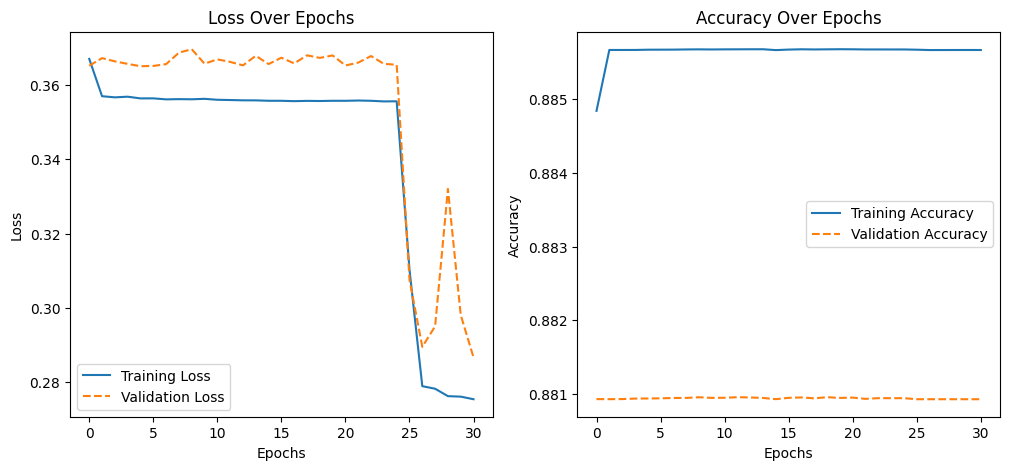

In [21]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs_range = range(len(loss))  # Number of epochs

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.show()


In [22]:
model.save("stft_200_model.h5")

# Threshold Tuning from Validation

In [23]:
# Get predictions on the validation data
y_pred_val = (model.predict(X_val) > 0.5).astype(int)  # Binarize predictions

153/153 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step


In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Flatten the arrays if necessary
y_true_val = Y_val.flatten()  # Flatten true labels to 1D if needed
y_pred_val = y_pred_val.flatten()  # Flatten predicted labels to 1D if needed

# Ensure that both are 1D and binary
print(f"True labels shape: {y_true_val.shape}, Predicted labels shape: {y_pred_val.shape}")

# Calculate Precision, Recall, F1-score
precision = precision_score(y_true_val, y_pred_val)
recall = recall_score(y_true_val, y_pred_val)
f1 = f1_score(y_true_val, y_pred_val)

# Print the scores
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

True labels shape: (14607000,), Predicted labels shape: (14607000,)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


In [25]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_true_val, y_pred_val)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.8809


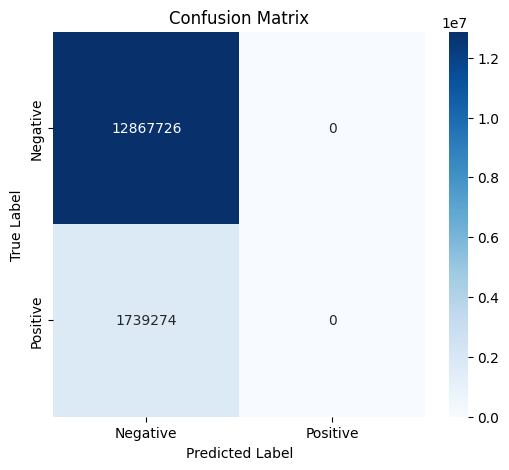

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Compute the confusion matrix
cm = confusion_matrix(y_true_val, y_pred_val)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [27]:
threshold = [0.1, 0.2, 0.3, 0.4, 0.5]

In [28]:
for th in threshold:
    # Get predictions on the validation data
    y_pred_val = (model.predict(X_val) > th).astype(int)  # Binarize predictions
    y_true_val = Y_val.flatten()  # Flatten true labels to 1D if needed
    y_pred_val = y_pred_val.flatten()
    #Calculate accuracy
    accuracy = accuracy_score(y_true_val, y_pred_val)
    # Calculate Precision, Recall, F1-score
    precision = precision_score(y_true_val, y_pred_val)
    recall = recall_score(y_true_val, y_pred_val)
    f1 = f1_score(y_true_val, y_pred_val)
    print("\n")
    print(f"Threshold: {th}")
    print(f"Accuracy: {accuracy:.4f}")
    # Print the scores
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\n")
    
    
    

153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step


Threshold: 0.1
Accuracy: 0.6146
Precision: 0.2322
Recall: 0.9700
F1-score: 0.3748


153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step


Threshold: 0.2
Accuracy: 0.6629
Precision: 0.2550
Recall: 0.9530
F1-score: 0.4024


153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step


Threshold: 0.3
Accuracy: 0.7889
Precision: 0.3046
Recall: 0.6030
F1-score: 0.4048


153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Threshold: 0.4
Accuracy: 0.8809
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


153/153 ━━━━━━━━━━━━━━━━━━━━ 30s 199ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Threshold: 0.5
Accuracy: 0.8809
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000




153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step


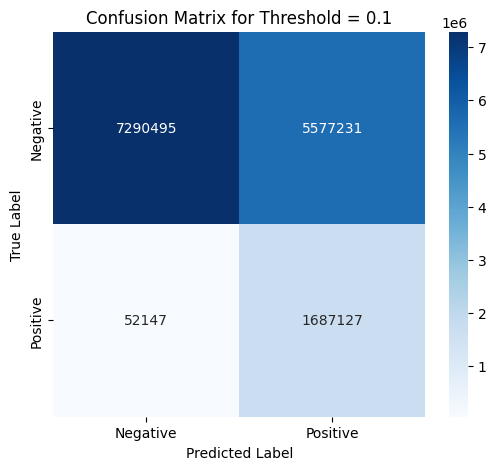

153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step


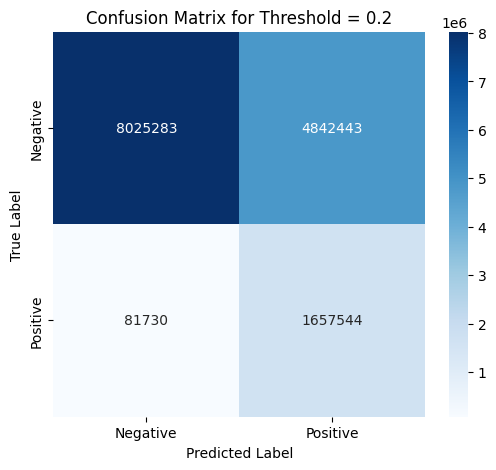

153/153 ━━━━━━━━━━━━━━━━━━━━ 30s 199ms/step


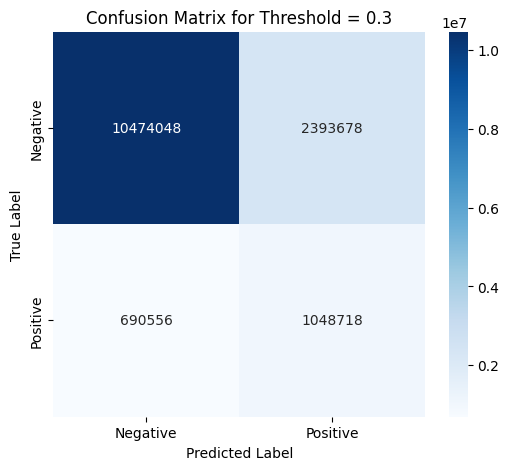

153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step


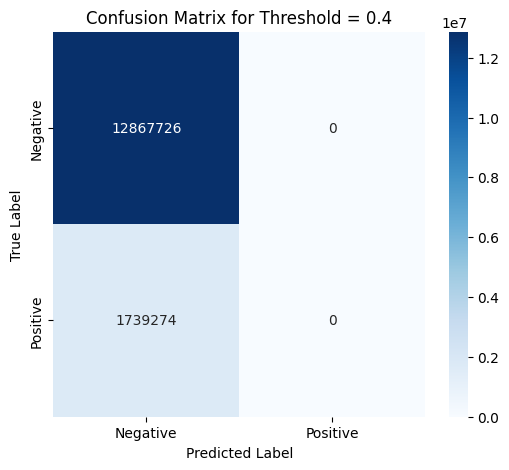

153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step


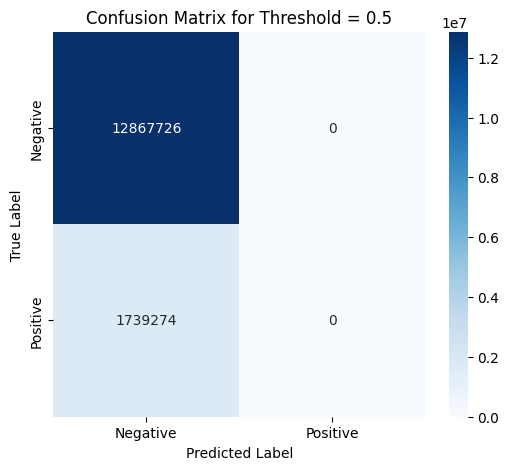

In [29]:
for th in threshold:
    y_pred_val = (model.predict(X_val) > th).astype(int)
    y_true_val = Y_val.flatten()  # Flatten true labels to 1D if needed
    y_pred_val = y_pred_val.flatten()
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true_val, y_pred_val)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title(f"Confusion Matrix for Threshold = {th}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# model testing with best threshold

In [43]:
# Get predictions on the validation data
y_pred = (model.predict(X_test) > 0.3).astype(int)  # Binarize predictions

153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step


In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Flatten the arrays if necessary
y_true_test = Y_test.flatten()  # Flatten true labels to 1D if needed
y_pred_test = y_pred.flatten()  # Flatten predicted labels to 1D if needed

# Ensure that both are 1D and binary
print(f"True labels shape: {y_true_test.shape}, Predicted labels shape: {y_pred_test.shape}")

accuracy = accuracy_score(y_true_val, y_pred_val)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision, Recall, F1-score
precision = precision_score(y_true_test, y_pred_test)
recall = recall_score(y_true_test, y_pred_test)
f1 = f1_score(y_true_test, y_pred_test)

# Print the scores
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

True labels shape: (14607000,), Predicted labels shape: (14607000,)
Accuracy: 0.8809
Precision: 0.2931
Recall: 0.6072
F1-score: 0.3954


In [45]:
import numpy as np

correct_1_indices = []

for i in range(len(Y_test)):
    true_labels = Y_test[i]
    pred_labels = y_pred[i]
    
    # Check if there's any position where both are 1
    if np.any((true_labels == 1) & (pred_labels == 1)):
        correct_1_indices.append(i)

print("Sample indices where model correctly predicted at least one '1':")
print(correct_1_indices)


Sample indices where model correctly predicted at least one '1':
[0, 1, 2, 5, 6, 8, 9, 11, 15, 17, 19, 23, 24, 27, 33, 34, 37, 38, 40, 41, 42, 43, 44, 47, 48, 50, 51, 54, 55, 57, 59, 60, 61, 63, 65, 66, 68, 72, 74, 75, 76, 78, 81, 85, 86, 90, 92, 94, 95, 100, 101, 102, 104, 105, 107, 109, 111, 112, 113, 116, 117, 119, 120, 124, 127, 130, 131, 132, 133, 135, 137, 143, 144, 145, 148, 149, 152, 154, 155, 157, 158, 160, 161, 162, 164, 168, 169, 172, 173, 174, 175, 176, 177, 180, 182, 183, 187, 188, 189, 191, 192, 193, 195, 196, 206, 207, 211, 213, 215, 216, 220, 224, 230, 231, 233, 238, 241, 242, 243, 247, 248, 256, 261, 262, 265, 266, 275, 276, 279, 284, 290, 291, 294, 295, 297, 298, 300, 303, 304, 305, 309, 310, 313, 314, 315, 320, 321, 322, 324, 327, 330, 332, 334, 337, 340, 345, 346, 347, 348, 349, 350, 351, 352, 358, 360, 363, 364, 365, 369, 372, 373, 374, 376, 378, 381, 382, 384, 387, 390, 400, 401, 402, 403, 404, 410, 411, 413, 414, 416, 419, 421, 425, 427, 429, 430, 437, 442, 444, 

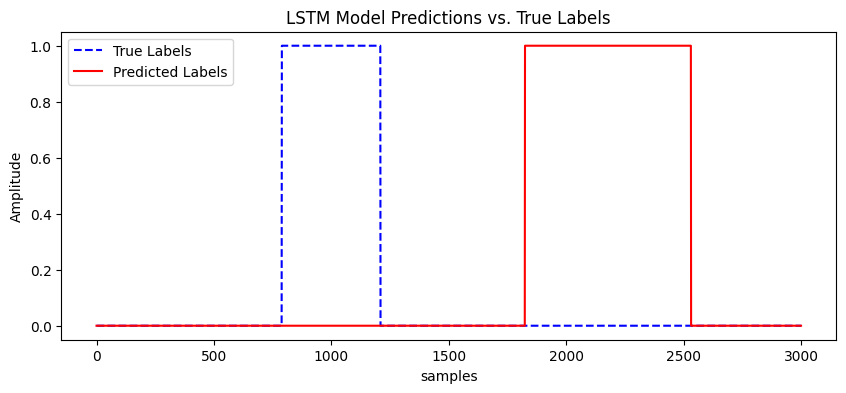

In [46]:
import matplotlib.pyplot as plt

sample_idx = 3# Choose a sample to visualize527
plt.figure(figsize=(10, 4))

# Plot true labels
plt.plot(Y_test[sample_idx], label="True Labels", linestyle="dashed", color="blue")
# Plot predicted labels
#plt.plot(Y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.plot(y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.xlabel("samples")
plt.ylabel("Amplitude")
plt.title("LSTM Model Predictions vs. True Labels")
plt.legend()
plt.show()


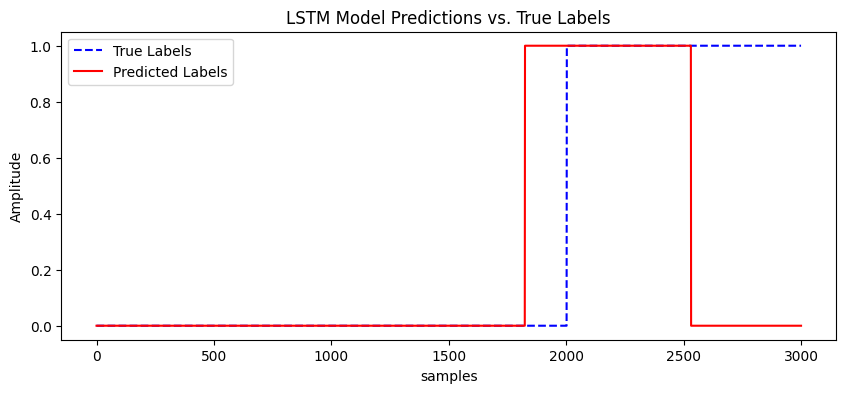

In [47]:
import matplotlib.pyplot as plt

sample_idx = 81# Choose a sample to visualize527
plt.figure(figsize=(10, 4))

# Plot true labels
plt.plot(Y_test[sample_idx], label="True Labels", linestyle="dashed", color="blue")
# Plot predicted labels
#plt.plot(Y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.plot(y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.xlabel("samples")
plt.ylabel("Amplitude")
plt.title("LSTM Model Predictions vs. True Labels")
plt.legend()
plt.show()


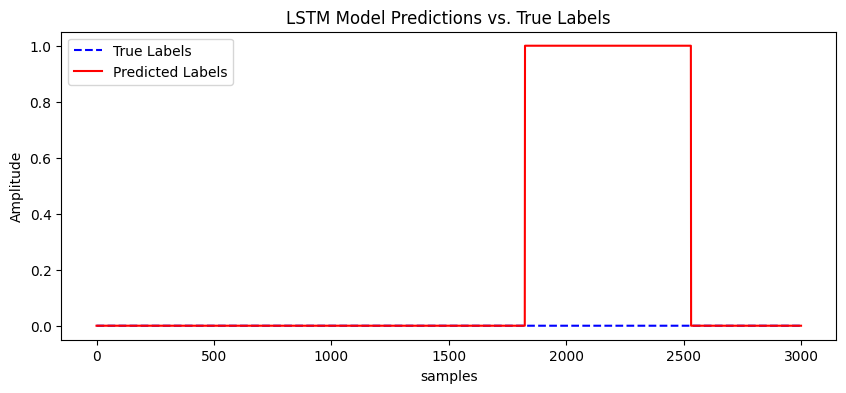

In [48]:
import matplotlib.pyplot as plt

sample_idx = 83# Choose a sample to visualize527
plt.figure(figsize=(10, 4))

# Plot true labels
plt.plot(Y_test[sample_idx], label="True Labels", linestyle="dashed", color="blue")
# Plot predicted labels
#plt.plot(Y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.plot(y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.xlabel("samples")
plt.ylabel("Amplitude")
plt.title("LSTM Model Predictions vs. True Labels")
plt.legend()
plt.show()


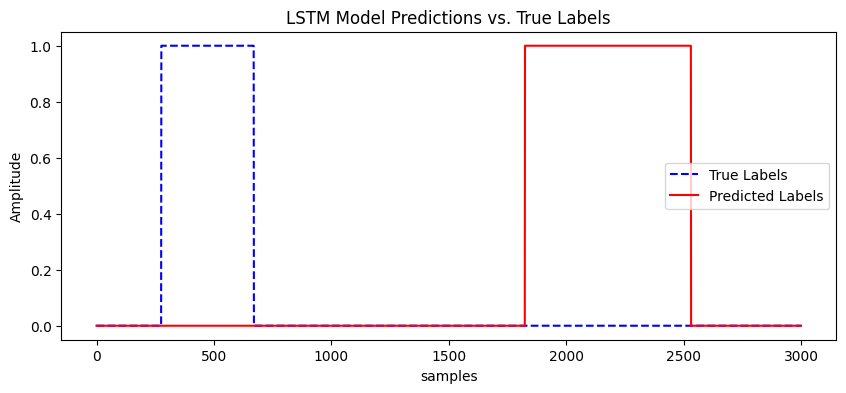

In [49]:
import matplotlib.pyplot as plt

sample_idx = 461# Choose a sample to visualize
plt.figure(figsize=(10, 4))

# Plot true labels
plt.plot(Y_test[sample_idx], label="True Labels", linestyle="dashed", color="blue")
# Plot predicted labels
#plt.plot(Y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.plot(y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.xlabel("samples")
plt.ylabel("Amplitude")
plt.title("LSTM Model Predictions vs. True Labels")
plt.legend()
plt.show()


In [50]:
import numpy as np

correct_1_indices = []

for i in range(len(Y_test)):
    true_labels = Y_test[i]
    pred_labels = y_pred[i]
    
    # Check if there's any position where both are 1
    if np.all((true_labels == 0) & np.any(pred_labels == 1)):
        correct_1_indices.append(i)

print("Sample indices where model correctly predicted at least one '1':")
print(correct_1_indices)


Sample indices where model correctly predicted at least one '1':
[4, 7, 10, 12, 13, 14, 16, 18, 20, 21, 22, 25, 26, 29, 30, 31, 32, 35, 36, 39, 45, 46, 49, 52, 53, 56, 58, 62, 64, 67, 69, 70, 71, 73, 77, 79, 80, 82, 83, 84, 87, 89, 91, 93, 96, 97, 98, 99, 103, 106, 108, 110, 114, 115, 118, 121, 122, 123, 125, 128, 134, 136, 138, 139, 140, 141, 142, 146, 147, 153, 163, 165, 166, 167, 170, 171, 178, 179, 181, 184, 185, 186, 190, 194, 197, 198, 199, 200, 201, 202, 203, 204, 208, 209, 210, 212, 214, 217, 218, 219, 221, 222, 223, 225, 226, 227, 228, 229, 232, 234, 235, 236, 240, 244, 245, 246, 249, 250, 251, 252, 255, 257, 258, 259, 260, 263, 264, 267, 268, 269, 270, 271, 272, 273, 274, 277, 278, 280, 281, 282, 283, 285, 286, 288, 289, 292, 293, 296, 299, 301, 302, 306, 307, 308, 312, 316, 317, 318, 319, 323, 325, 326, 328, 329, 331, 333, 335, 336, 338, 339, 341, 342, 353, 354, 355, 356, 357, 359, 361, 362, 366, 368, 370, 371, 375, 377, 379, 380, 383, 385, 386, 388, 389, 391, 392, 393, 394,

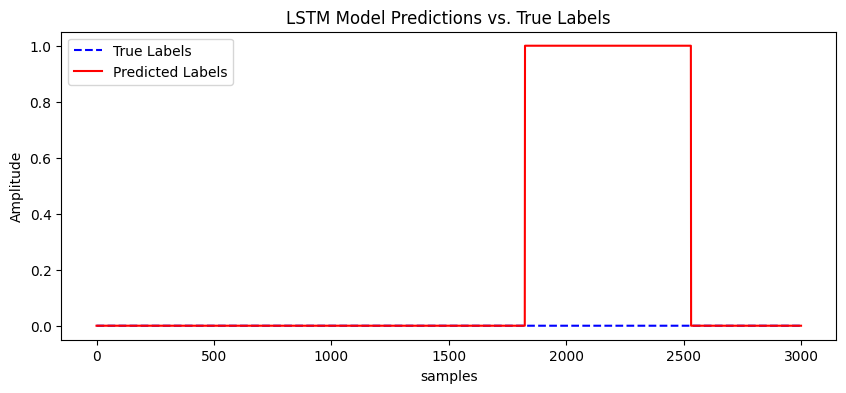

In [56]:
import matplotlib.pyplot as plt

sample_idx = 4387# Choose a sample to visualize
plt.figure(figsize=(10, 4))

# Plot true labels
plt.plot(Y_test[sample_idx], label="True Labels", linestyle="dashed", color="blue")
# Plot predicted labels
#plt.plot(Y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.plot(y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.xlabel("samples")
plt.ylabel("Amplitude")
plt.title("LSTM Model Predictions vs. True Labels")
plt.legend()
plt.show()


In [52]:
import numpy as np

correct_1_indices = []

for i in range(len(Y_test)):
    true_labels = Y_test[i]
    pred_labels = y_pred[i]
    
    # Check if there's any position where both are 1
    if np.any((true_labels == 1) & np.all(pred_labels == 0)):
        correct_1_indices.append(i)

print("Sample indices where model correctly predicted at least one '1':")
print(correct_1_indices)


Sample indices where model correctly predicted at least one '1':
[]


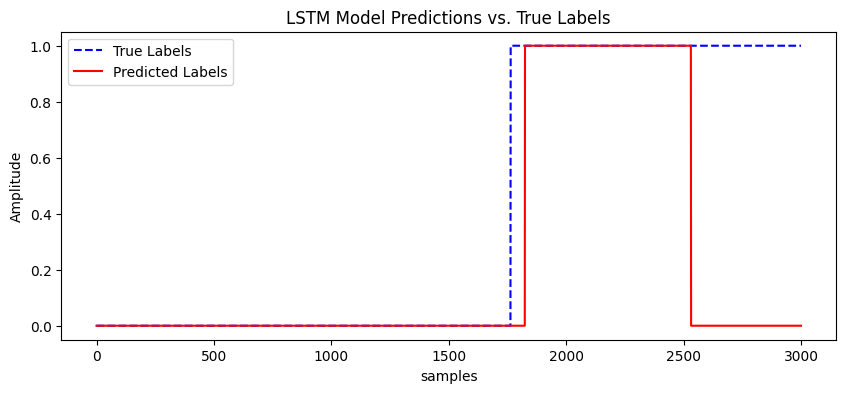

In [53]:
import matplotlib.pyplot as plt

sample_idx = 59# Choose a sample to visualize
plt.figure(figsize=(10, 4))

# Plot true labels
plt.plot(Y_test[sample_idx], label="True Labels", linestyle="dashed", color="blue")
# Plot predicted labels
#plt.plot(Y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.plot(y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.xlabel("samples")
plt.ylabel("Amplitude")
plt.title("LSTM Model Predictions vs. True Labels")
plt.legend()
plt.show()


# mean onset calculation

In [54]:
import numpy as np

onset_differences = []

for i in range(len(Y_test)):
    true_labels = Y_test[i]
    pred_labels = y_pred[i]
    
    true_indices = np.where(true_labels == 1)[0]
    pred_indices = np.where(pred_labels == 1)[0]
    
    if len(true_indices) > 0 and len(pred_indices) > 0:
        # Compute the difference: predicted - true
        onset_diff = pred_indices[0] - true_indices[0]
        onset_differences.append(onset_diff)

if onset_differences:
    mean_onset_difference = np.mean(onset_differences)
    print("Mean Onset Difference (predicted - true):", mean_onset_difference)
else:
    print("No valid onset pairs found.")


Mean Onset Difference (predicted - true): -8.983326385994165


In [55]:
sampling_rate = 100  # Hz
time_error_seconds = mean_onset_difference / sampling_rate
print("Mean onset error in seconds:", time_error_seconds)

Mean onset error in seconds: -0.08983326385994164
